In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

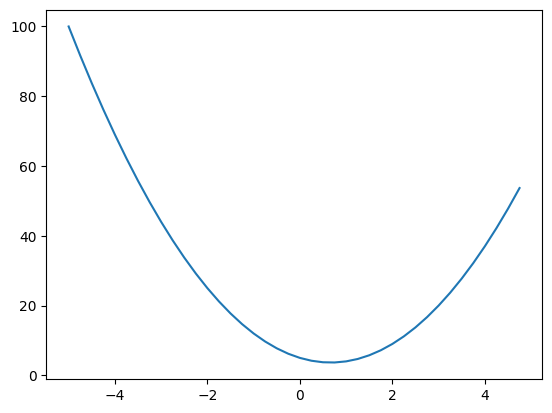

In [5]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

![Alt text](assets/image.png)
Working through derivatives

In [6]:
h = 0.000001
x = 3.0
(f(x + h) - f(x))/h

14.000003002223593

In [7]:
h = 0.000001
x = -3.0
(f(x + h) - f(x))/h

-21.999997002808414

In [8]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [9]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
d

4.0

In [10]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c
print(f'd1: {d1}') 
print(f'd2: {d2}') 
print(f'slope: {(d2-d1)/h}') 

d1: 4.0
d2: 4.0001
slope: 0.9999999999976694


In [60]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [52]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [12]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [13]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

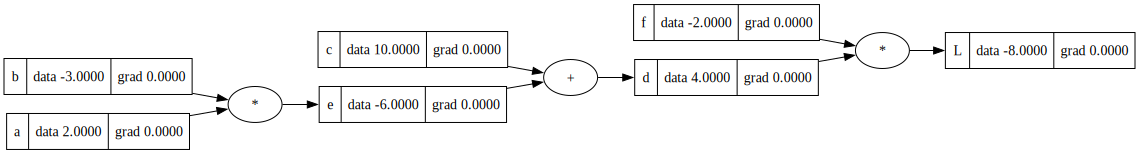

In [14]:
draw_dot(L)

In [15]:
L = d * f

# dL/dd =? f

# (f(x+h)-f(x))/h

# (d+h)*f - d*f)/h
# (d*f + h*f - d*f) / h(h*f)/h
# f

In [16]:
f.grad = 4.0
d.grad = -2.0

In [17]:
d = c + e

# dd / dc = 1.0
# dd / de = 1.0

# (f(x+h) - f(x)) / h
# ((c+h + e) - (c + e))/h
# (c + h + e - c - e)/h
# h/h
# 1.0

# e = a * b
# de / da = b

# dL / de = -2.0
# dL / da = (dL / de) * (de / da)

In [18]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

# Chain rule
![Alt text](assets/chain.png)
If z depends on y and y depends on x, then z depends on x as well

Intuitively, the chain rule states that knowing the instantaneous rate of change of z relative to y and that of y relative to x allows one to calculate the instantaneous rate of change of z relative to x as the product of the two rates of change.

As put by George F. Simmons: "If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man."


In [19]:
c.grad = -2.0 * 1
e.grad = -2.0 * 1

In [20]:
def lol():
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)

lol()

-3.9999999999995595


The above took us through piece by piece back propagation. Dervied the values from L and got all the way back to the beginning of the equation by locally applying the chain rule. 
**Back propagation = recursive application of chain rule backwards through the chain graph**

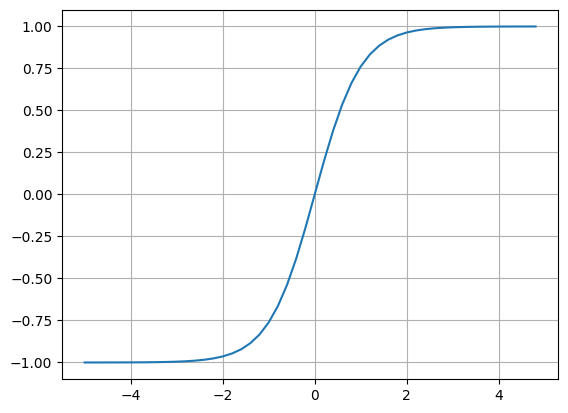

In [21]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [55]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

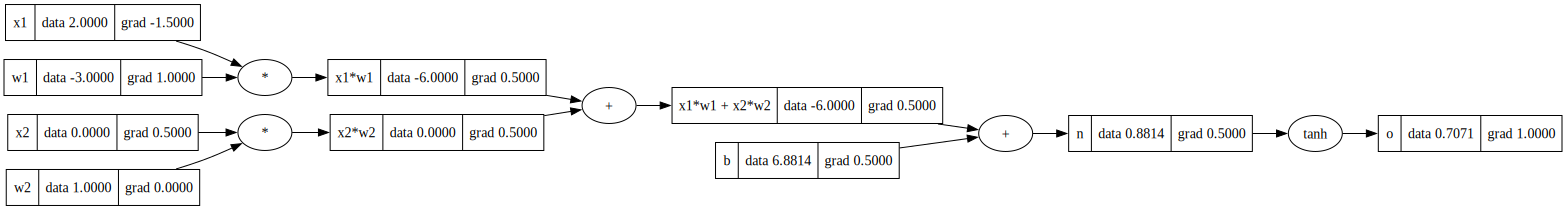

In [58]:
draw_dot(o)

In [57]:
o.backward()

In [25]:
o.grad = 1.0

In [26]:
o._backward()

In [27]:
n._backward()

In [28]:
b._backward()

In [29]:
x1w1x2w2._backward()

In [30]:
x2w2._backward()
x1w1._backward()

In [31]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [32]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [33]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [34]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [35]:
n.grad = 0.5

In [36]:
o.grad = 1.0

In [37]:
1 - o.data**2

0.4999999999999999

In [38]:
# o = tanh(n)
# do/dn = 1 - tanh(n)**2
# do/dn = 1 - o**2

# Topological Sort
Use topological sort to ensure all dependencies have fired before we begin back propagating
![sort](assets/topological_sort.png)

In [39]:
# WIll only add a value to the list after all of its children have been added to the list
topo_sort = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo_sort.append(v)
build_topo(o)
topo_sort

[Value(data=6.881373587019543),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [40]:
o.grad = 1.0

topo_sort = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo_sort.append(v)
build_topo(o)

for node in reversed(topo_sort):
    node._backward()

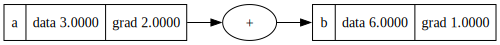

In [41]:
a = Value(3.0, label='a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

# In current Value setup the gradient is wrong when running backward

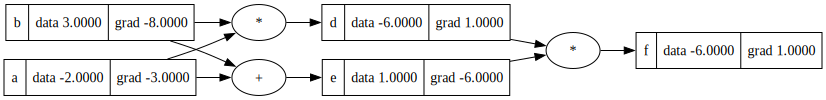

In [42]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

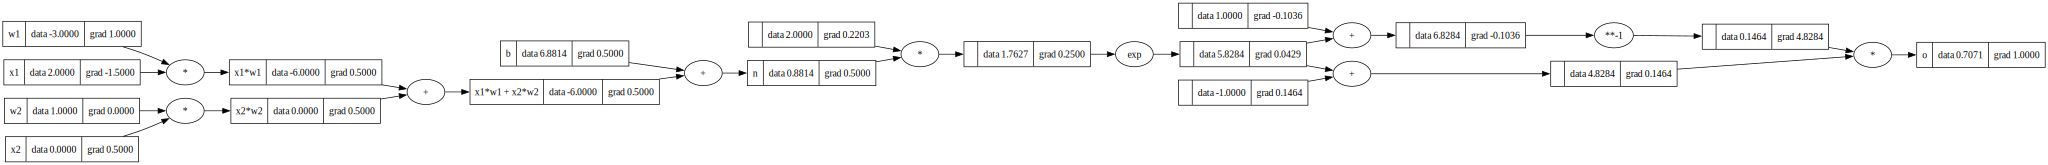

In [61]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# Changing how we are implementing o from before
e = (2*n).exp()
o = (e-1) / (e+1)
o.label = 'o'
o.backward()
draw_dot(o)

# PyTorch
Now doing the same general calculation and back propagation but in pytorch

In [62]:
import torch
x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True

x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True

w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True

w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True

b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [68]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [65]:
torch.Tensor([[1,2,3], [4,5,6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [91]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.paramters()
        #     params.extend(ps)
        # return params

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [92]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.6852829102237253)

In [94]:
n.parameters()

[Value(data=0.05081068469262373),
 Value(data=0.46353286446179287),
 Value(data=0.9965456018079659),
 Value(data=-0.8163777620511512),
 Value(data=-0.27750966600564686),
 Value(data=0.0660958283076627),
 Value(data=0.6006432763726979),
 Value(data=-0.19727524656940987),
 Value(data=-0.39943202481057893),
 Value(data=0.09238691702297896),
 Value(data=-0.9601300187104231),
 Value(data=0.567085708683206),
 Value(data=-0.5495317876329344),
 Value(data=-0.8496050868395297),
 Value(data=0.8445823787221087),
 Value(data=-0.3773325614202103),
 Value(data=0.7585064550484757),
 Value(data=-0.33382773734670246),
 Value(data=-0.18413652209934206),
 Value(data=0.19681910718149842),
 Value(data=0.9655468739287143),
 Value(data=0.5428770096310727),
 Value(data=0.26650066820154894),
 Value(data=0.7227013401543918),
 Value(data=0.793987049338404),
 Value(data=-0.8494091091021916),
 Value(data=0.7837106019916555),
 Value(data=0.5652940901756911),
 Value(data=0.7347165146328756),
 Value(data=0.8954979118

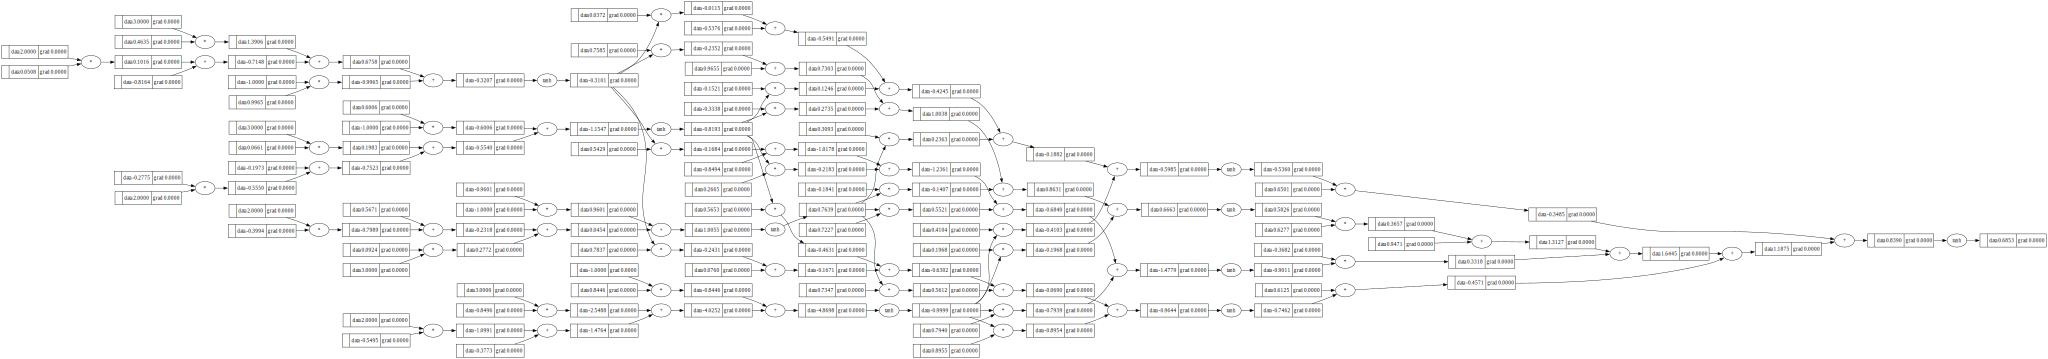

In [93]:
draw_dot(n(x))

In [143]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [96]:
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=6.209437447202175)

In [135]:
ypred = [n(x) for x in xs]
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=0.00221531927806425)

In [136]:
loss.backward()

In [149]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data)

0 0.0001897380142846782
1 0.0001894262852096104
2 0.00018911554320554961
3 0.00018880578367601363
4 0.000188497002052709
5 0.00018818919379533206
6 0.000187882354391342
7 0.00018757647935575822
8 0.00018727156423095512
9 0.00018696760458644047
10 0.00018666459601866917
11 0.0001863625341508314
12 0.00018606141463264582
13 0.0001857612331401689
14 0.00018546198537558968
15 0.00018516366706705206
16 0.00018486627396842767
17 0.00018456980185915705
18 0.00018427424654404278
19 0.00018397960385305596


In [112]:
n.layers[0].neurons[0].w[0].grad

2.286820452090896

In [111]:
n.layers[0].neurons[0].w[0].data

0.03930253877538722

In [134]:
for p in n.parameters():
    p.data += -0.05  * p.grad

In [108]:
n.layers[0].neurons[0].w[0].data

0.03930253877538722

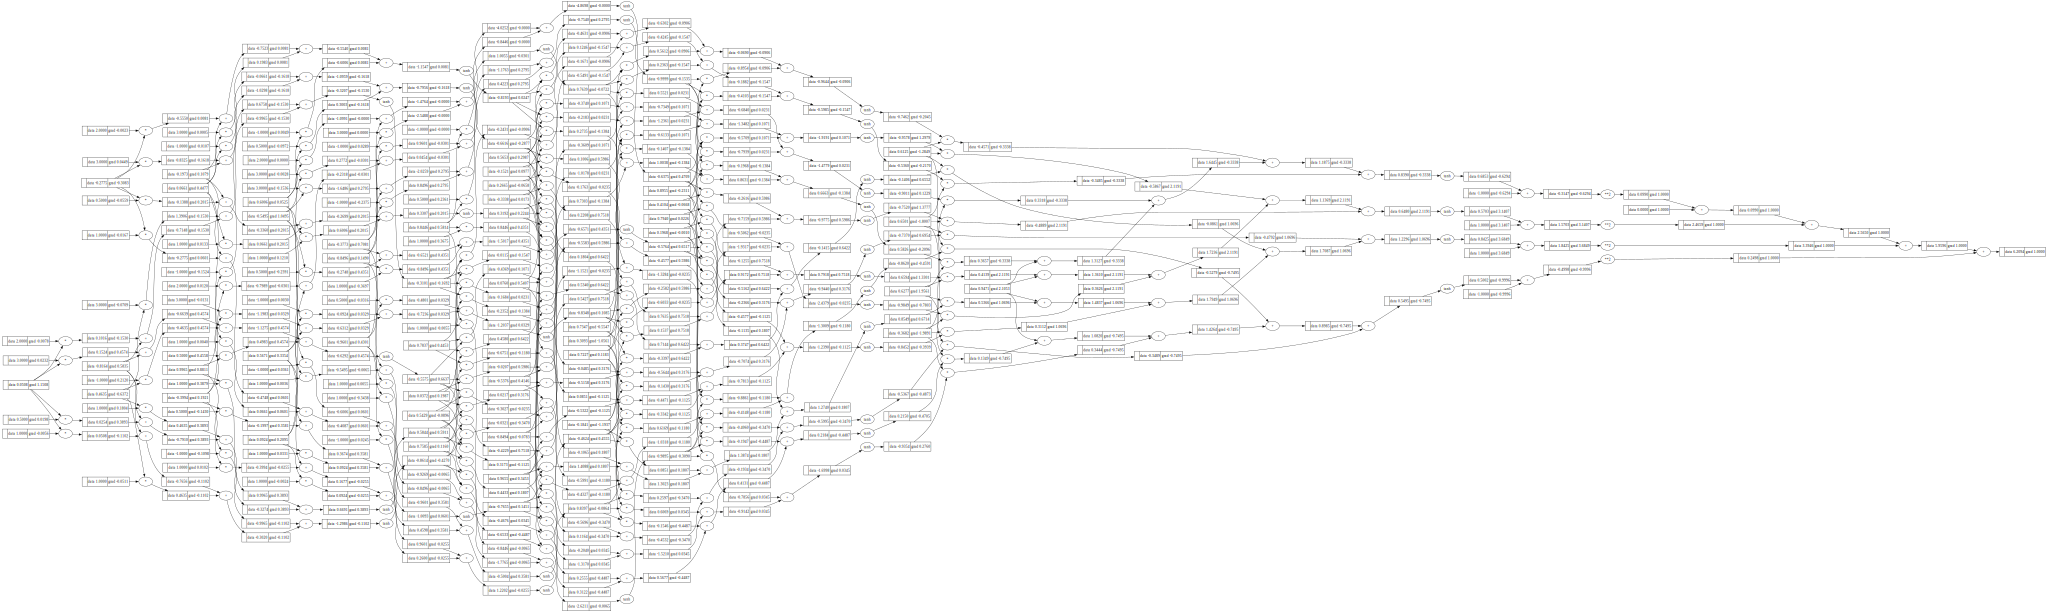

In [99]:
draw_dot(loss)